In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy

## Study of the hydrodynamic field generated by the passage of containerships

### Abstract

This study is done using the results of a measurement campaign *in situ*, carried out by the Hydraulic Engineering Division of the Canadian Coast Guard (**CCG**) in the autumn of 2004 on island *Île-des-Barques*, Quebec.

The campaign *in situ* had two goals to accomplish. First, it planned to study the impact of lengthening the containerships passing through *the Saint Lawrence River* on the erosion of the river banks. Estimating the effect of growing the size of vessels on coastal erosion had become necessary since 2004 with the commissioning of a new series of 294 m long containerships to add to the conventional series of 245 m.

Second, the field measurement aimed to obtain real-scale data that can be used as a basis for experimental validation of the numerical model "Ship-Generated Hydrodynamics" (**SGH**), created for the needs of the CCG. In order to validate the SGH model, the experimental data of the hydrodynamic field generated by the passage of containerships were collected and processed.

### 1. _In situ_ raw data

The field measurement was fulfilled on the site of the navigation channel located between the islands *Île-des-Barques* and *Île à la Pierre* (the *Sorel* - *Quebec* section of the *St. Lawrence River*). The site was chosen as one of the places most vulnerable to coastal erosion between *Montreal* and *Trois-Rivières*. In fact, monitoring of the erosion of the shores of _Île-Des-Barques_ had indicated a recession of about 1 m per year.

**Fig.1** Map of the site of the experiment *in situ* near island **Île-des-Barques**, Quebec, Canada [1]
<img src="data/map.jpg" style="max-height: 400px" />

Note: *The thick red lines represent the real coastlines, the thick dashed red line – the trajectory of the containership.*

The data recorded during the field measurement were pre-processed by the manufacturers' software, or by EXCEL. The wave heights were found from the water surface elevations recorded by wave gauges (capacitance meters, model "WG-50") at the measurement points in the river. As a fact, these are time series, which have to be processed further.

The water surface elevations were recorded with frequency 4.926 Hz (approximately 5 records per second):
   $$ T = 1/f = 0.203 sec. $$

A custom function `open_the_initial_dataset` is created here for reading the initially recorded files.

In [3]:
def open_the_initial_dataset(inp_file, skip_foot_rows=381, T_per=0.203):
    ''' This function opens and arranges the initially recorded dataset (without subtracting the mean surface level). '''
    
    dir_path = "https://raw.githubusercontent.com/Geo2020/Hydrodynamic-field-of-the-ship-waves/main/data"
    file_path = dir_path + '/' + inp_file
    
    inp_data = pd.read_fwf(file_path, header=None, skipfooter=skip_foot_rows)
    inp_data.columns = ["elevations"]

    time_rec_array = np.array([i * T_per for i in range(len(inp_data.elevations))])
    time_rec_series = pd.Series(time_rec_array)

    waves_df = pd.concat([inp_data, time_rec_series], axis=1)
    waves_df.columns = ["elevations", "time_record"]
    
    return waves_df

The water level of the river was measured by means of a laser level, referred to the geodesic mark, installed on the foundation of the _Île-des-Barques_ observation tower. The basic file that contains the absolute surface elevation is transformed to a `pandas DataFrame` and named _waves_abs_.

In [4]:
waves_abs = open_the_initial_dataset("vagues.txt", skip_foot_rows=381, T_per=0.203)
waves_abs

,elevations,time_record
0,0.167,0.000
1,0.149,0.203
2,0.157,0.406
3,0.151,0.609
4,0.133,0.812
...,...,...
10330,0.226,2096.990
10331,0.182,2097.193
10332,0.136,2097.396
10333,0.141,2097.599


The wave records from the wave gauges were collected as well; they include the subscript 'g' (plus a number or capital letter) in the names of the files or the corresponding DataFrames.

In [5]:
g1_nf0203_in_abs = open_the_initial_dataset("g1-nf203.in", skip_foot_rows=169, T_per=0.203)
g1_nf0203_in_abs

,elevations,time_record
0,-0.056,0.000
1,-0.040,0.203
2,0.033,0.406
3,0.027,0.609
4,0.020,0.812
...,...,...
3947,0.007,801.241
3948,0.039,801.444
3949,-0.007,801.647
3950,-0.032,801.850


Having the above tables, we can visualise the waves (the absolute water surface elevations) during the passage of the containership. For this purpose, we create a custom function `plot_elevations`:

In [6]:
def plot_elevations(df, plot_size=(10, 6), x_step=120, x_lim=(0, 2060), y_lim=(-0.5, 0.5), col='b', title=""):
    ''' This function plots the water surface elevation up to the water level. '''
    
    plt.figure(figsize=plot_size)
    plt.plot(df.time_record, df.elevations, color=col, lw='0.5')  # , label='text', ls='-.', lw='2.5'

    plt.title(f'{title}')
    # plt.legend(loc="lower right")  # legend's location
    plt.xticks(range(x_lim[0], x_lim[1] + 1, x_step))
    plt.xlabel("Time, [sec]")
    plt.ylabel("Water surface elevations, [m]")
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.grid(True)
    plt.show()

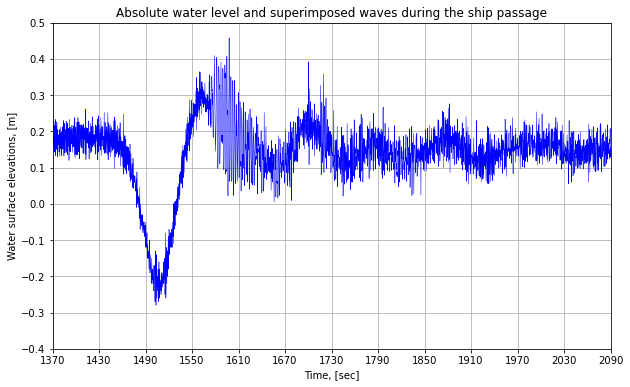

In [7]:
plot_elevations(df=waves_abs, x_step=60, x_lim=(1370, 2090), y_lim=(-0.4, 0.5), 
                title="Absolute water level and superimposed waves during the ship passage")

### 2. Pre-processing the data

#### 2.1. The "zero-crossing" method
Capacitance gauges recorded the water surface elevations. To obtain the heights and periods of waves, we applied a method called in the technical literature *zero-crossing*, [2]. This method determines the height of each wave as the vertical distance from the maximum elevation (the wave crest) to the minimum elevation (the trough) between two consecutive intersections of the waveform of the rippling water with the horizontal line of the surface of calm water (the mean level.) The wave period is determined as the distance on the horizontal axis of time between two consecutive intersections of each wave with the mean water level.

In case the recording series is long, this method requires the application of a calculation program. In our case, we used the freeware `Z-cross`.

**Fig.2**  Definition of wave parameters in the *zero-crossing* method
<img src="data/zero-crossing.jpg" style="max-height: 225px" />

#### 2.2. Relative surface water elevations
For the following calculation, we will use the relative surface elevation about the mean water level; the latter is found after pre-processing the wave records with the programme `Z-cross`.

In [8]:
def calculate_relative_water_elevations(dataframe, mean_level=0.1500985):
    ''' This function recalculates the water surface elevations relative to the mean water level. '''

    result_df = copy.deepcopy(dataframe)
    result_df.elevations = result_df.elevations - mean_level
    
    return result_df

The mean water surface elevation calculated by `Z-cross` is 0.1500985 m, which should be removed from the data.

In [9]:
waves_rel = calculate_relative_water_elevations(dataframe=waves_abs, mean_level=0.1500985)  # see 'vagues-0203_stats.out'
waves_rel

,elevations,time_record
0,0.016901,0.000
1,-0.001099,0.203
2,0.006902,0.406
3,0.000901,0.609
4,-0.017098,0.812
...,...,...
10330,0.075902,2096.990
10331,0.031901,2097.193
10332,-0.014098,2097.396
10333,-0.009099,2097.599


The wave heights obtained by `Z-cross` as relative waves (surface elevations) are shown graphically.

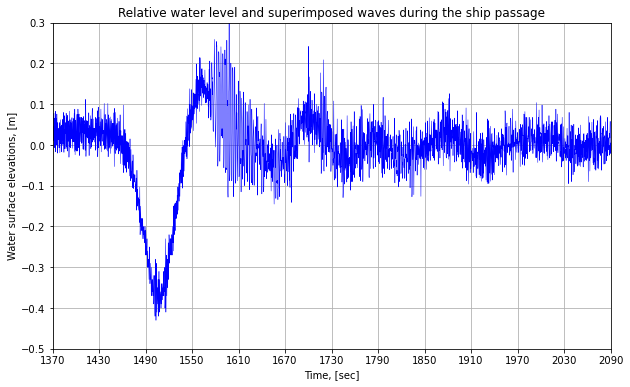

In [10]:
plot_elevations(df=waves_rel, x_step=60, x_lim=(1370, 2090), y_lim=(-0.5, 0.3), 
                title="Relative water level and superimposed waves during the ship passage")

### 3. Processed waves

The recorded wave data processed with `Z-cross` return the wave heights and periods (as well as the elevations of the wave crest and trough); these files are read by a custom created function `read_processed_waves`:

In [11]:
def read_processed_waves(inp_file, skip_top_rows=26):
    ''' This function reads the processed wave records '''
    
    dir_path = "data"
    file_path = os.path.join(dir_path, inp_file)
    waves_processed = pd.read_fwf(file_path, skiprows=26)
    # setting a column as an index:
    waves_processed = waves_processed.set_index("INDEX")
    # resetting the row indexes (from 0 to the end)
    result_waves_processed = waves_processed.reset_index(drop=True)
    
    return result_waves_processed

In [12]:
waves_processed_0203 = read_processed_waves("vagues-0.203.OUT")
# waves_processed_0203

The outputs of the processed waves are printed by `Z-cross` in tables. Below is shown such output for waves recorded by gauge #1.

In [13]:
g1_nf_0203 = read_processed_waves("gauge1-non-filtered_0.203.out")  # , skip_top_rows=26
g1_nf_0203

,HEIGHT,PERIOD,CREST HEIGHT,TROUGH DEPTH
0,0.088,1.015,0.033,-0.055
1,0.082,1.015,0.027,-0.055
2,0.059,1.218,0.016,-0.043
3,0.152,0.812,0.095,-0.057
4,0.086,1.015,0.061,-0.025
...,...,...,...,...
729,0.142,1.218,0.062,-0.080
730,0.083,0.812,0.029,-0.054
731,0.120,1.218,0.061,-0.059
732,0.122,1.624,0.067,-0.055


### 4. Wave filtering

The gauge records represent elevations of the water surface that correspond to waves in nature. In fact, during the passage of a vessel, there are ship waves and wind waves that are superimposed. To separate them, a numerical procedure called **filtering** was applied. This procedure helps "filter out" the short-period wind-generated waves and recorded noise.

The wave filtering was done in two stages, in order to first remove the **drawdown**${}^{*)}$ of the recorded signal and then separate the ship waves from the wind waves using a low-pass filter and the **Fast Fourier Transform** (*FFT*).

The recorded wave data cover a period before and during the passage of the vessel. The waves before the beginning of the ship **wake**${}^{*)}$ generation were analyzed with the *FFT* procedure to determine the frequency of the wind waves. Another *FFT* procedure applied to the whole wave dataset confirmed that the energy of the ship waves was at a different frequency than those of the wind waves and defined the cutoff frequency of 0.6 to 0.7 Hz for the separation of both samples, [3].

${}^{*)}$ - *the ship-generated waves are of type* **wakes** and **drawdown** *(see next section)*

**Fig. 3 a** Wave spectrum before the ship passage
<img src="data/Fig.22a.jpg" style="max-height: 350px" />

**Fig. 3 b** Wave spectrum of the superposed wind waves and ship-generated *wakes*
<img src="data/Fig.22b.jpg" style="max-height: 350px" />

After using a low-pass filter, the resulting wave signal, which represents only the ship waves, was further analyzed by the "zero-crossing method" to determine the heights and periods of the different waves in each sample. The results are provided in a tabular form, in which the main wave characteristics are calculated (including the elevations of the wave crests and troughs ), [3], [4].

In [14]:
g1_f_0203 = read_processed_waves("gauge1-filtered_0.203.out")  # , skip_top_rows=26
g1_f_0203

,HEIGHT,PERIOD,CREST HEIGHT,TROUGH DEPTH
0,0.0094,2.030,0.0087,-0.0007
1,0.0025,1.421,0.0011,-0.0014
2,0.0092,2.030,0.0033,-0.0059
3,0.0061,1.827,0.0028,-0.0033
4,0.0015,1.218,0.0006,-0.0008
...,...,...,...,...
355,0.0272,1.827,0.0060,-0.0212
356,0.0424,1.827,0.0242,-0.0182
357,0.0579,1.827,0.0240,-0.0339
358,0.0536,2.030,0.0307,-0.0229


The above type data are further processed to obtain the relative time of each wave from the beginning of the field record; it is assigned to be the average of the corresponding wave period: for the first wave, it is the half period, for the second - the period of the first wave plus the half period of the second wave, etc.

Below are shown the newly formatted tables of the waves recorded by different gauges: the non-filtered data (with substring 'nf' in the name of the files or DataFrames) as well as the filtered data (with substring 'f' in the name).

In [15]:
def arrange_processed_waves_table(waves_processed):
    ''' This function calculates the relative time of each wave '''
    
    time_processed_array = np.array([0.0] * len(waves_processed))
    time_processed_array[0] = waves_processed.loc[0, ["PERIOD"]] / 2

    for i in range(1, len(waves_processed)):
        time_processed_array[i] = (time_processed_array[i - 1] + (waves_processed.loc[i - 1, ["PERIOD"]] + waves_processed.loc[i, ["PERIOD"]]) / 2)
    time_processed_series = pd.Series(time_processed_array)

    waves_processed = pd.concat([waves_processed, time_processed_series], axis=1)
    waves_processed.columns = ["wave_height", "wave_period", "crest_height", "through_depth", "time"]
    
    return waves_processed

In [16]:
waves_processed_0203_time = arrange_processed_waves_table(waves_processed_0203)
waves_processed_0203_time

,wave_height,wave_period,crest_height,through_depth,time
0,0.024,0.609,0.0069,-0.0171,0.3045
1,0.076,1.624,0.0589,-0.0171,1.4210
2,0.041,1.218,0.0309,-0.0101,2.8420
3,0.062,1.421,0.0389,-0.0231,4.1615
4,0.040,0.812,0.0169,-0.0231,5.2780
...,...,...,...,...,...
1795,0.056,1.421,0.0299,-0.0261,2092.6255
1796,0.030,0.609,0.0129,-0.0171,2093.6405
1797,0.022,0.406,0.0189,-0.0031,2094.1480
1798,0.069,1.015,0.0269,-0.0421,2094.8585


In [17]:
# Non-filtered waves:
g1_nf_0203_time = arrange_processed_waves_table(g1_nf_0203)
g1_nf_0203_time

,wave_height,wave_period,crest_height,through_depth,time
0,0.088,1.015,0.033,-0.055,0.5075
1,0.082,1.015,0.027,-0.055,1.5225
2,0.059,1.218,0.016,-0.043,2.6390
3,0.152,0.812,0.095,-0.057,3.6540
4,0.086,1.015,0.061,-0.025,4.5675
...,...,...,...,...,...
729,0.142,1.218,0.062,-0.080,795.5570
730,0.083,0.812,0.029,-0.054,796.5720
731,0.120,1.218,0.061,-0.059,797.5870
732,0.122,1.624,0.067,-0.055,799.0080


In [18]:
# Filtered waves:
g1_f_0203_time = arrange_processed_waves_table(g1_f_0203)
g1_f_0203_time

,wave_height,wave_period,crest_height,through_depth,time
0,0.0094,2.030,0.0087,-0.0007,1.0150
1,0.0025,1.421,0.0011,-0.0014,2.7405
2,0.0092,2.030,0.0033,-0.0059,4.4660
3,0.0061,1.827,0.0028,-0.0033,6.3945
4,0.0015,1.218,0.0006,-0.0008,7.9170
...,...,...,...,...,...
355,0.0272,1.827,0.0060,-0.0212,788.7565
356,0.0424,1.827,0.0242,-0.0182,790.5835
357,0.0579,1.827,0.0240,-0.0339,792.4105
358,0.0536,2.030,0.0307,-0.0229,794.3390


### 5. Wakes and Drawdown

The waves generated by a passage of a vessel are divided into *wave wakes* and *drawdown*, superimposed on each other. **Wave wakes** (shortly called **wakes**) are produced by the moving ship, caused by density differences of the fluids above and below the free surface and gravity (surface tension) (https://en.wikipedia.org/wiki/Wake).

**Drawdown** refers to the lowering of the water surface elevation (and its consecutive raise) as a result of the vessel movement. Otherwise called, it is the change of the water level relative to the initial calm surface.

**Fig. 4** *Wake* pattern generated by a small boat
<img src="data/Fjordn_surface_wave_boat.jpg" style="max-height: 250px" />

The wave filtering was done using a low-pass filter and the fast Fourier transform, [3]. The level of drawdown was determined using an average a few seconds (3 to 6) on the recording. The superimposed *wind* and *wave wakes* were then obtained by subtracting the average draft level from the recorded values, resulting in waves relative to a constant zero water level.

#### 5.1. Wave wakes

In order to visualise the processed wave data, we create a custom function `plot_wave_heights`:

In [19]:
def plot_wave_heights(df, plot_size=(10, 6), x_step=120, x_lim=(0, 2060), y_lim=(-0.5, 0.5), col="navy", title=""):
    ''' This function plots the wave heights of the processed data '''
    
    plt.figure(figsize=plot_size)
    plt.plot(df.time, df.wave_height, color=col, lw='1')  # , label='text', ls='-.', lw='2.5'

    plt.title(f'{title}')
    # plt.legend(loc="lower right")  # legend's location
    plt.xticks(range(x_lim[0], x_lim[1] + 1, x_step))
    plt.xlabel("Time, [sec]")
    plt.ylabel("Wave heights, [m]")
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    plt.grid(True)
    plt.show()

In [20]:
# plot_wave_heights(df=waves_processed_0203_time, x_step=120, x_lim=(1250, 1970), y_lim=(0, 0.5), title="waves (vagues)")

The non-filtered waves from gauge #1 are visualised below. As a fact, these are the wave wakes superposed to the wind waves.

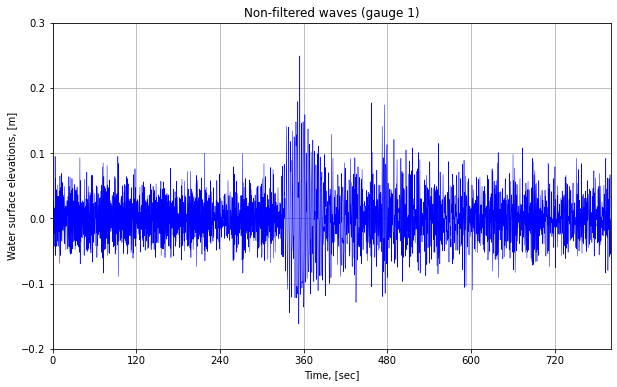

In [21]:
plot_elevations(df=g1_nf0203_in_abs, x_step=120, x_lim=(0, 800), y_lim=(-0.2, 0.3), title="Non-filtered waves (gauge 1)")

The filtered waves (from gauge #1) are plotted as well. Both plots (the previous and the next) use the initial (non-processed) wave records, [3].

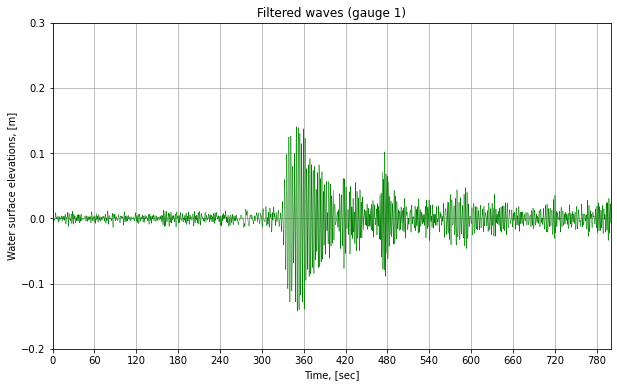

In [22]:
g1_f_in_abs = open_the_initial_dataset("g1-f.in", skip_foot_rows=93, T_per=0.203)
# g1_f_in_abs

plot_elevations(df=g1_f_in_abs, x_step=60, x_lim=(0, 800), y_lim=(-0.2, 0.3), col='g',  title="Filtered waves (gauge 1)")

The processed non-filtered waves include *the wave wakes superimposed to the wind waves*; the filtered waves - only *wakes*. The two variants of **wakes** (combined with and separated from the wind waves) as recorded by gauge #1 are plotted below.

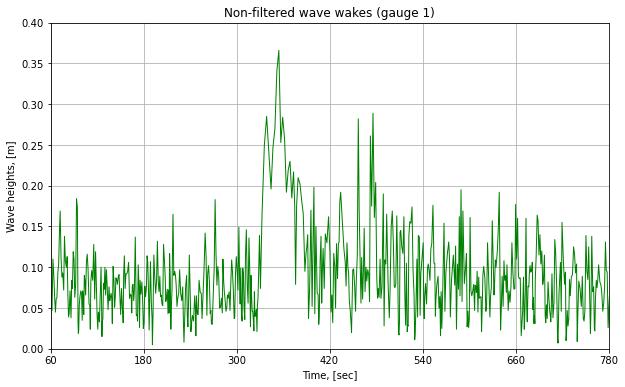

In [23]:
plot_wave_heights(df=g1_nf_0203_time, x_step=120, x_lim=(60, 780), y_lim=(0, 0.4), col="g", 
                  title="Non-filtered wave wakes (gauge 1)")

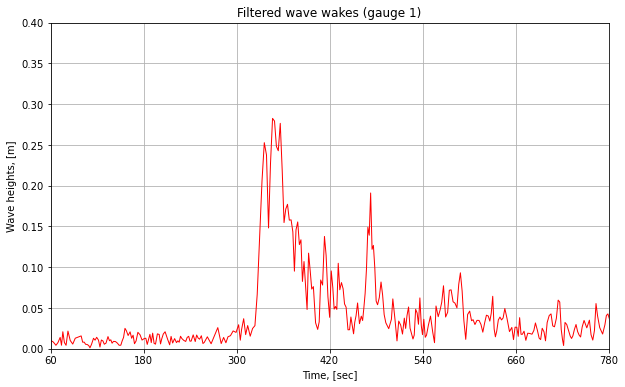

In [24]:
plot_wave_heights(df=g1_f_0203_time, x_step=120, x_lim=(60, 780), y_lim=(0, 0.4), col='r', 
                  title="Filtered wave wakes (gauge 1)")

#### 5.2. Drawdown
The mean water level change during the ship passage can be found, applying an averaging of a few seconds to the records of the free surface elevations. In fact, this is the *drawdown* of the ship-generated waves.

In [25]:
def average_water_elevations(df):
    ''' This function calculates the average water surface elevations of the initial record data 
    for given time interval (from 3 to 6 sec)'''
    
    wave_array = df.elevations.to_numpy()
    t_increment = 6
    interval_number = 1
    help_list = []
    avg_elevations = []
    avg_time = []
    for i in range(len(df)):
        if df.time_record[i] > interval_number * t_increment:
            avg_elevations.append(np.mean(help_list))
            avg_time.append(interval_number * t_increment - t_increment / 2)
            interval_number += 1
            help_list = []
        
        help_list.append(wave_array[i])
    
    x_time = np.array(avg_time)
    z_elevations = np.array(avg_elevations)
    
    return x_time, z_elevations

The drawdown obtained by applying an average of 6 sec to the water surface elevations records, is calculated and plotted below.

In [26]:
t_z_waves_abs = average_water_elevations(waves_abs)  # 2 arrays
# t_z_waves_abs

In [27]:
def plot_mean_water_surface(x, z, plot_size=(10, 6), x_step=120, x_lim=(0, 2060), y_lim=(-0.5, 0.5), inp_color="blue", 
                            line_weight="0.5", title=""):
    ''' This function plots the mean water surface level '''
    
    plt.figure(figsize=plot_size)  #  plot_size
    plt.plot(x, z, color=inp_color, lw=line_weight)

    plt.title(f"Mean water surface level ({title})")
    plt.xticks(range(x_lim[0], x_lim[1] + 1, x_step))
    plt.xlim(x_lim)
    plt.ylim(y_lim)
    
    plt.xlabel("Time, [sec]")
    plt.ylabel("Water surface elevations, [m]")

    plt.grid(True)
    plt.show()

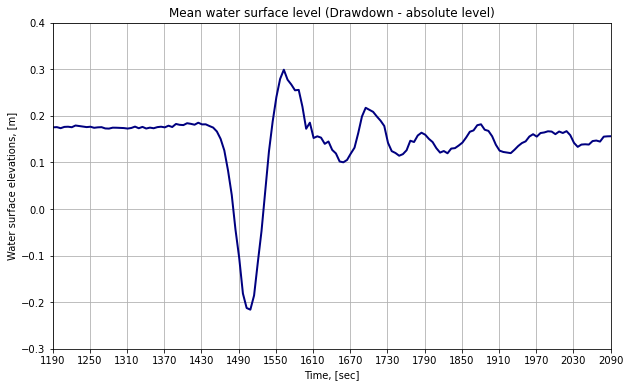

In [28]:
avg_time_waves_abs = t_z_waves_abs[0]
avg_elev_waves_abs = t_z_waves_abs[1]
plot_mean_water_surface(avg_time_waves_abs, avg_elev_waves_abs, x_step=60, x_lim=(1190, 2090), y_lim=(-0.3, 0.4), 
                        inp_color="navy", line_weight="2", title = "Drawdown - absolute level")

### 6. Wave Energy

To assess the impact of the ship waves on coastal erosion the wave energy is often used. Considering the Airy linear theory for waves of small amplitudes [2], we seek for the **energy density** (*wave energy per unit area*) according to the formula:
$$ E = \frac{\rho g H^2}{8} \;\;\;\;\; (1) $$ 
, where $ \rho $ is the mass density of water; for fresh water = 1000 $ kg/{m^3} $,

$ g $ - gravitational acceleration equal to 9.807 $ m/{s^2} $,

$ H $ - wave height, [m].

Knowing the energy density, **E** we can find the **wave energy flux** (frequently called **wave power**); the latter is defined as the rate at which energy is transmitted in the direction of wave propagation across a vertical plane perpendicular to the direction of wave advance and extending down the entire depth. According to the linear theory, the average *wave power* (per unit wave crest width) is: 
$$ P = n_pCE \;\;\;\;\;\;\; (2) $$
, where $ C $ is the *phase velocity* (or *wave celerity*),

$ n_p $ - coefficient depending on the ratio of the water depth, $ d $ to the wavelength, $ L $ given as:

$$ n_p = \frac{1}{2} \left[ 1 + \frac{4\pi \frac{d}{L}}{sinh(4\pi \frac{d}{L})} \right] \;\;\;\;\; (3) $$

To find the wave power, it remains to determine the *phase velocity* **C** and the wavelength **L**; they can be found from the Airy wave theory (see [2]). The water depth **d** is known from the initial experimental conditions (this is the depth at the gauge installation point in the river).

To find the **unit wave energy** (per unit of the wave crest) we must multiply the wave power **P** by the wave period **T**. The physical sense of the product (**P⋅T**) can be understood by analyzing the definition of the wave energy flux, given in formula (2) - it is the energy of a wave transmitted for the period of its passage through a vertical plane (of water depth and unit width crest), perpendicular to the radius of its propagation.

In the campaign *in situ*, two different containerships were observed: one - of the conventional length 
**length overall (LOA)**${}^{*)}$ of 245 m and the other - with LOA = 294 m. 

The observed containerships were:

__"OOCL Montreal"__ (_LOA_ : 294 m, _Beam_ ${}^{**)}$: 32.20 m, _Draught_ ${}^{***)}$: 10.78 m),

__"Canmar Honour"__ (_LOA_ : 245 m, _Beam_ : 32.28 m, _Draught_ : 10.78 m.
_____

${}^{*)}$ - *length over all, LOA: : the maximum vessel length* (see https://en.wikipedia.org/wiki/Length_overall)

${}^{**)}$ - *maximum width of the ship (hull) at waterline*

${}^{***)}$ - *draught or draft of a ship's hull is the vertical distance between the waterline and the bottom of the hull (keel). Draught determines the minimum depth of water a ship can safely navigate* (see https://en.wikipedia.org/wiki/Draft_(hull))

**Fig. 5** The passage of the containership "OOCL Montreal" in front of *Île-des-Barques*
<img src="data/containership_Montreal.jpg" style="max-height: 250px" />

#### 6.1. The wave energy parameters of the non-filtered waves

All consecutive calculations are present below in tabular and graphic forms. In the tables, only waves whose heights are greater than 20% of the maximum height of each recording series were selected because waves with heights less than 20% of the maximum height give an energy contribution of less than 4% (see formula (1) ).

In [29]:
def create_wave_energy_table(df, depth=2.11, rho=1000):
    ''' This function calculates the wave energy acc. to the Airy's theory '''
    
    max_wave_height = df.wave_height.max()
    highest_waves_df = df[df.wave_height > 0.2 * max_wave_height][["wave_height", "wave_period"]]
    
    highest_waves_df["L_0"] = 9.807*(highest_waves_df["wave_period"]**2) / (2*np.pi)
    highest_waves_df["d/L_0"] = depth / highest_waves_df["L_0"]
    
    # water_type_criteria:
    d_L0_array = highest_waves_df["d/L_0"].tolist()
    type_water_list = []
    for i in range(len(d_L0_array)):
        if d_L0_array[i] >= 0.5:
            type_water_list.append("deep")
        elif (0.05 < d_L0_array[i]) and (d_L0_array[i] < 0.5):
            type_water_list.append("transitional")
        elif d_L0_array[i] <= 0.05:
            type_water_list.append("shallow")

    highest_waves_df.insert(4, "water_type", type_water_list, True)
    
    # L = L_0*{ tanh[ (2pi*SQRT(d/g) / T)^(1/5) ] }^(2/3)
    highest_waves_df["L"] = highest_waves_df["L_0"] * ((np.tanh((2*np.pi*np.sqrt(depth/9.807) / 
                                                        highest_waves_df["wave_period"]) ** 1.5)) ** (2/3))
    highest_waves_df["C"] = highest_waves_df["L"] / highest_waves_df["wave_period"]
    highest_waves_df["d/L"] = depth / highest_waves_df["L"]
    # E = rho*g*H^2 / 8, where (rho*g) ~ 10^4 J/m^4
    highest_waves_df["E"] = rho * 9.807 * highest_waves_df["wave_height"]**2 / 8
    
    highest_waves_df["C"] = highest_waves_df["L"] / highest_waves_df["wave_period"]
    highest_waves_df["d/L"] = depth / highest_waves_df["L"]
    highest_waves_df["E"] = rho * 9.807 * highest_waves_df["wave_height"]**2 / 8
    
    arg = 4 * np.pi * depth / highest_waves_df["L"]
    highest_waves_df["n_p"] = 0.5 * (1 + arg / np.sinh(arg))

    highest_waves_df["P"] = highest_waves_df["n_p"] * highest_waves_df["C"] * highest_waves_df["E"]

    highest_waves_df["PxT"] = highest_waves_df["P"] * highest_waves_df["wave_period"] / 1000
    
    return  highest_waves_df

In [30]:
g1_nf_0203_energy = create_wave_energy_table(g1_nf_0203_time, depth=2.11, rho=1000)
g1_nf_0203_energy

,wave_height,wave_period,L_0,d/L_0,water_type,L,C,d/L,E,n_p,P,PxT
0,0.088,1.015,1.608009,1.312182,deep,1.607881,1.584120,1.312286,9.493176,0.500001,7.519180,0.007632
1,0.082,1.015,1.608009,1.312182,deep,1.607881,1.584120,1.312286,8.242784,0.500001,6.528792,0.006627
3,0.152,0.812,1.029126,2.050284,deep,1.029124,1.267394,2.050288,28.322616,0.500000,17.947956,0.014574
4,0.086,1.015,1.608009,1.312182,deep,1.607881,1.584120,1.312286,9.066571,0.500001,7.181283,0.007289
5,0.087,0.812,1.029126,2.050284,deep,1.029124,1.267394,2.050288,9.278648,0.500000,5.879851,0.004774
...,...,...,...,...,...,...,...,...,...,...,...,...
728,0.074,0.812,1.029126,2.050284,deep,1.029124,1.267394,2.050288,6.712891,0.500000,4.253939,0.003454
729,0.142,1.218,2.315533,0.911237,deep,2.313651,1.899549,0.911978,24.718543,0.500121,23.482719,0.028602
730,0.083,0.812,1.029126,2.050284,deep,1.029124,1.267394,2.050288,8.445053,0.500000,5.351604,0.004346
731,0.120,1.218,2.315533,0.911237,deep,2.313651,1.899549,0.911978,17.652600,0.500121,16.770043,0.020426


We add a simple function to extract the main **wave energy parameters** calculated above.

In [31]:
def print_main_energy_params(df, title=""):
    ''' This function prints the main wave energy parameters from the given table '''
    
    text = f'Main Wave Energy parameters for {title}:\n'
    text += f'- maximum wave height, (Hmax) = {round(df["wave_height"].max(), 2)} m\n'
    text += f'- maximum energy density, (Emax) = {round(df["E"].max())} J/m2\n'
    text += f'- maximum wave power, (Pmax) = {round(df["P"].max())} J/(m.sec)\n'
    text += f'- maximum unit wave energy, (Pmax.Tmax) = {round(1000 * df["PxT"].max())} J/m\n'
    text += f'- sum(Emax): {df["E"].sum():.0f} J/m2\n'
    text += f'- sum(Pmax): {df["P"].sum():.0f} J/(m.sec)\n'
    text += f'- sum(Pmax.Tmax): {df["PxT"].sum():.1f} kJ/m\n'

    return print(text)

In [32]:
# Write the Wave Energy dataframe name:
print_main_energy_params(g1_nf_0203_energy, title='containership "OOCL Montreal" (non-filtered waves)')  # Non-filtered waves

Main Wave Energy parameters for containership "OOCL Montreal" (non-filtered waves):
- maximum wave height, (Hmax) = 0.37 m
- maximum energy density, (Emax) = 164 J/m2
- maximum wave power, (Pmax) = 399 J/(m.sec)
- maximum unit wave energy, (Pmax.Tmax) = 1053 J/m
- sum(Emax): 7528 J/m2
- sum(Pmax): 9197 J/(m.sec)
- sum(Pmax.Tmax): 16.4 kJ/m



#### 6.2. The wave energy parameters of the filtered waves
are calculated below.

In [33]:
g1_f_0203_time = arrange_processed_waves_table(g1_f_0203)
# g1_f_0203_time

g1_f_0203_energy = create_wave_energy_table(g1_f_0203_time, depth=2.11)
g1_f_0203_energy

,wave_height,wave_period,L_0,d/L_0,water_type,L,C,d/L,E,n_p,P,PxT
142,0.0667,3.248,16.466009,0.128143,transitional,12.870549,3.962607,0.163940,5.453783,0.766871,16.573008,0.053829
143,0.1381,3.045,14.472078,0.145798,transitional,11.771120,3.865721,0.179252,23.379410,0.739459,66.831025,0.203500
144,0.2060,3.045,14.472078,0.145798,transitional,11.771120,3.865721,0.179252,52.021231,0.739459,148.704874,0.452806
145,0.2528,2.842,12.606788,0.167370,transitional,10.657543,3.750015,0.197982,78.343023,0.708140,208.042834,0.591258
146,0.2377,2.842,12.606788,0.167370,transitional,10.657543,3.750015,0.197982,69.263519,0.708140,183.931870,0.522734
...,...,...,...,...,...,...,...,...,...,...,...,...
266,0.0709,2.233,7.782762,0.271112,transitional,7.273762,3.257394,0.290084,6.162241,0.595257,11.948499,0.026681
283,0.0644,2.030,6.432035,0.328045,transitional,6.162871,3.035897,0.342373,5.084145,0.558249,8.616536,0.017492
321,0.0597,2.030,6.432035,0.328045,transitional,6.162871,3.035897,0.342373,4.369129,0.558249,7.404737,0.015032
322,0.0573,2.030,6.432035,0.328045,transitional,6.162871,3.035897,0.342373,4.024903,0.558249,6.821348,0.013847


In [34]:
# Write the Wave Energy dataframe name:
print_main_energy_params(g1_f_0203_energy, title='containership "OOCL Montreal" (filtered waves)')  # for Filtered waves

Main Wave Energy parameters for containership "OOCL Montreal" (filtered waves):
- maximum wave height, (Hmax) = 0.28 m
- maximum energy density, (Emax) = 98 J/m2
- maximum wave power, (Pmax) = 238 J/(m.sec)
- maximum unit wave energy, (Pmax.Tmax) = 628 J/m
- sum(Emax): 1561 J/m2
- sum(Pmax): 3304 J/(m.sec)
- sum(Pmax.Tmax): 8.1 kJ/m



The wave energy parameters for the containership **"Canmar Honour"** are found as follows.

In [35]:
gA_f_0203 = read_processed_waves("gaugeA-filtered_0.203.out")  # , skip_top_rows=26
# gA_f_0203

gA_f_0203_time = arrange_processed_waves_table(gA_f_0203)  # -> g1_f_0203_time 
# gA_f_0203_time

gA_f_0203_energy = create_wave_energy_table(gA_f_0203_time, depth=1.90, rho=1000)  # d = 1.90 m (for gauge A); 1.82 m (g.B)
gA_f_0203_energy

,wave_height,wave_period,L_0,d/L_0,water_type,L,C,d/L,E,n_p,P,PxT
168,0.2227,2.233,7.782762,0.244129,transitional,7.150083,3.202008,0.265731,60.797626,0.618569,120.419507,0.268897
169,0.5546,2.436,9.262130,0.205136,transitional,8.223361,3.375764,0.231049,377.056055,0.659687,839.684443,2.045471
170,0.5461,2.233,7.782762,0.244129,transitional,7.150083,3.202008,0.265731,365.586829,0.618569,724.103695,1.616924
171,0.2828,2.436,9.262130,0.205136,transitional,8.223361,3.375764,0.231049,98.040383,0.659687,218.330891,0.531854
172,0.1605,2.639,10.870139,0.174791,transitional,9.293438,3.521576,0.204445,31.578846,0.697962,77.618451,0.204835
208,0.1123,1.827,5.209948,0.364687,transitional,5.045047,2.761383,0.376607,15.459865,0.541667,23.124117,0.042248
209,0.1382,2.030,6.432035,0.295396,transitional,6.085010,2.997542,0.312243,23.413281,0.577590,40.536586,0.082289
210,0.1256,2.233,7.782762,0.244129,transitional,7.150083,3.202008,0.265731,19.338619,0.618569,38.303256,0.085531
214,0.1310,2.030,6.432035,0.295396,transitional,6.085010,2.997542,0.312243,21.037241,0.577590,36.422829,0.073938
215,0.1212,1.827,5.209948,0.364687,transitional,5.045047,2.761383,0.376607,18.007417,0.541667,26.934622,0.049210


In [36]:
# Write the Wave Energy dataframe name:
print_main_energy_params(gA_f_0203_energy, title='containership "Canmar Honour" (filtered waves)')  # for Filtered waves

Main Wave Energy parameters for containership "Canmar Honour" (filtered waves):
- maximum wave height, (Hmax) = 0.55 m
- maximum energy density, (Emax) = 377 J/m2
- maximum wave power, (Pmax) = 840 J/(m.sec)
- maximum unit wave energy, (Pmax.Tmax) = 2045 J/m
- sum(Emax): 1243 J/m2
- sum(Pmax): 2483 J/(m.sec)
- sum(Pmax.Tmax): 5.6 kJ/m



The wave energy of the non-filtered waves was calculated by a subcontractor who participated in the measurement campaign, [1], [3]:

**Fig. 6** Energy parameters of the non-filtered ship waves generated by the containership **Canmar Honor** (*in French*)
<img src="data/Table_A6.jpg" style="max-height: 600px" />

For estimating the wave energy generated by the containerships, we consider only the filtered waves, i.e. the "pure" *wave wakes* (filtering out the wind waves). The main energy characteristics of the wakes, generated by both containerships are summarized below.

Wave energy parameters of the *wave wakes* generated by **"Canmar Honour"** (245 m long):
- maximum wave height, (Hmax) = 0.55 m
- maximum energy density, (Emax) = 377 J/m2
- maximum unit wave energy, (Pmax.Tmax) = 2045 J/m
- sum(Pmax.Tmax): 5.6 kJ/m

Wave energy parameters of the *wakes* generated by **"OOCL Montreal"** (294 m long):
- maximum wave height, (Hmax) = 0.28 m
- maximum energy density, (Emax) = 98 J/m2
- maximum unit wave energy, (Pmax.Tmax) = 628 J/m
- sum(Pmax.Tmax): 8.1 kJ/m

### 7. The impact of lengthening of the containerships on bank erosion

The obtained results in the previous section represent that the higher maximum wave is generated by the shorter vessel (that seems a little bit strange) but the total passage wave energy is greater for the longer containership. The maximum ship-wave height does not necessarily increase with the increasing length of containerships; however, the maximal wave height is not the only important characteristic of the impact of waves on shore erosion.

The distribution of waves in the wave train is the most important factor for the total wave energy. Our field observations showed the wave distribution in the wave train changes with the lengthening of the containerships so that the number of waves in the wave train increases with the lengthening of the ship, respectively the energy produced by the passage of the vessel increases. This causes the growth of the energy induced by the "elongated" containerships, which is a greater erosion factor than the maximum wave height of the ship-waves. As a result, the longer containerships emit more wave energy in the wave train than the conventional containerships.

Our experimental results state that the **total unit wave energy** of *wakes* emitted by the longer containership (294 m) is 8.1 kJ/m, for the shorter vessel (245 m long) - 5.6 kJ/m.

### 8. Comparison with the results of the subcontractor

Some of the results in the field measurement campaign were processed and delivered to the Canadian Coast Guard by a subcontractor, others - were obtained by us. A comparison of the outcomes is present below.

**Fig. 7** Time series of the waves generated by the passage of "OOCL Montreal", [3]
<img src="data/Fig.23a.jpg" />

Our results given above are the same (see the plots "Absolute water level and superimposed waves during the ship passage", "Mean water surface level (Drawdown - absolute level)"), "Filtered waves (gauge 1)").

### 9. Validation of the numerical model SGH

One of the main goals of the measurement campaign was to validate the software module SGH. For this task, the observed field data were simulated as initial and boundary conditions by the developers of the SGH.

Below are shown some pictures and graphs representing the experimental and the numerical results.

**Fig. 8** *Wake* and *drawdown* ship waves visualization - initial conditions of the simulation module SGH, [1]
<img src="data/PIE_image.jpg" style="max-height: 400px" />

The **wake** determined by our field measurement processing and analysis were compared with those calculated by the developers (the wave wakes on the plot are shown above in larger scales - see our graphs: "Non-filtered wave wakes (gauge 1)", "Filtered wave wakes (gauge 1)").

**Fig. 9** Comparison of the experimentally determined wakes with the numerical results from SGH [1]
<img src="data/wakes_comparison_PIE.jpg" style="max-height: 400px" />

By analyzing the wakes a phase lag of the numerical results and of the experimental data between one and two minutes is observed. This lag can be considered in the order of determining the passage trajectory of the vessel (coordinates of its position were recorded every minute.)

Comparison of the **drawdown** obtained from the field data with those calculated with the software SGH was done as well. On the graph above, named "Mean water surface level (Drawdown - absolute level)", the absolute water level of the drawdown is plotted. Below we show the drawdown as relative level (up to the mean calm water level).

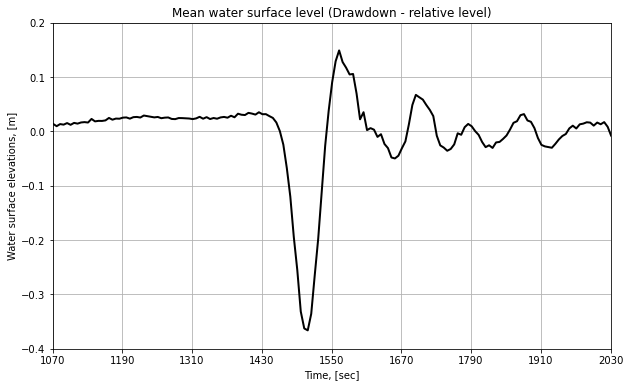

In [37]:
t_z_waves_rel = average_water_elevations(waves_rel)

avg_time_waves_rel = t_z_waves_rel[0]
avg_elev_waves_rel = t_z_waves_rel[1]

plot_mean_water_surface(avg_time_waves_rel, avg_elev_waves_rel, x_step=120, x_lim=(1070, 2030), y_lim=(-0.4, 0.2), 
                        inp_color="black", line_weight="2", title = "Drawdown - relative level")

A comparison of the experimentally obtained *drawdown* with the calculated one is shown in the plot below.

**Fig. 10** Comparison of the experimentally obtained drawdown versus its numerical result [1]:
<img src="data/drawdown_comparison_PIE.jpg" style="max-height: 400px" />

Analyzing the above graph, we can say that the extreme drawdown values calculated by the SGH deviate from their corresponding experimental values of about 20% in the case of the passage of the containership "OOCL Montreal". There is also a phase lag of one to two minutes between the extremes of the drawdown calculated numerically and that obtained by the measured data, which could be accepted as comparable with the precision of the determination of the navigation trajectory (every one minute).

###### Finally, we can conclude that the SGH model represents relatively well the wake and drawdown of the ship-waves - qualitatively the agreement is acceptable while quantitatively there are differences between the numerical results and experimental data.

### 10. Conclusion

The present study summarises the results of a measurement campaign *in situ*, carried out by the Canadian Coast Guard in 2004. The **purpose of the campaign** was to estimate the effect of the lengthening of containerships on **bank erosion in the St. Lawrence River** as well as to collect field data for **validating the numerical model "Ship-Generated Hydrodynamics" (SGH)**. It can be concluded that the two main objectives are achieved.

The number of waves and their distribution in the wave train is the main factor for the emitted total wave energy. Our results confirm that the wave energy increases with the enlargement of the containership *length overall (LOA)* that causes a larger erosion factor. As a result, the elongated containerships induce more wave energy in a wave train than the conventional containerships, respectively their impact on **riverbank erosion** is more destructive.

As for **the numerical model SGH**, we determined that it simulates the wake and drawdown modes of the ship-generated waves relatively well - qualitatively the agreement with the field data is good, quantitatively - acceptable.

#### Future work concept

The ship-generated waves analyzed in the energy approach (present above) were *wave wakes* and not *drawdown*. However, the drawdown is an indivisible part of the ship waves and is considered to be the primary factor in the bank erosion caused by ship waves, [5].

As continuing of the present study, we can investigate the impact of **drawdown** ship waves on riverbank erosion. For this purpose, we have to estimate the radiated wave energy from drawdown on shores.

### References

1. Étude des caractéristiques du champ hydrodynamique généré par le passage des navires de type porte-conteneurs, rapport interne, préparé par G. Valkov, Canadian Coast Guard, 2005-06 (in French).

2. Thompson, E. F. Hydrodynamic Analysis and Design Conditions. Coastal Engineering Manual, EM 1110-2-1100, U.S. Army Corps of Engineers, Washington, DC. Pt.II Coastal Hydrodynamics, Ch.II-8, 2002, 62 p.

3. W.F. BAIRD & ASSOCIATES COASTAL ENGINEERS LTD. 2005. Digital filtering of ship wakes and drawdown. Prepared for Canadian Coast Guard, Quebec region, Summary of results.

4. Gharbi, S.; Hamdi, S.; Valkov, G.; et al., 2008. Field Measurements of Ship Waves Along the St. Lawrence River Waterway, Canada. Conf. OCEANS 2008, Quebec City, Canada, 15-18 Sept., 2008. Published in OCEANS 2008, VOLS 1-4, p.2229-2238.

5. A Lagrangian Sediment Transport Model Technical Documentation, PSed v.4.3. Document Release 1.3 (Published as an Annex to the SedSim Reference Manual). Prepared by M. Davies, Pacific International Engineering Corp., February, 2006.